## Notebook Object
#### 1. Finds:
        - longest street
        - shortest street  
        - straightest street
        - curviest Street

       in Boulder,Colorado, USA; New york, NY and Los Angeles  
   
#### 2. Gives a function for above information in any cities (with OSMnx Relations)

In [14]:
import osmnx as ox
import shapely
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
import fiona
%pylab inline
import numpy as np
from collections import Counter
from geopy.distance import vincenty
from shapely.geometry import Point
import pylab as pl

Populating the interactive namespace from numpy and matplotlib


## Functions for street length and curviness

In [2]:
def howlong(place, ntype='drive'):
    """
    Find the shortest and longest roads by name in a given geographical area in OSM.
    
    Args:
        1. place: a string of place name
        2. ntype: network type (not tested yet)
    Return:
        1. name and length of the shortest road (length problem unsolved)
        2. name and length of the longest road (length problem unsolved)
        3. network graph plot of given place
    """
    
    # try different API query results
    try:
        G = ox.project_graph(ox.graph_from_place(place,network_type='drive', which_result=1))
    except:
        G = ox.project_graph(ox.graph_from_place(place, network_type='drive',which_result=2))
    
    # convert road segments as df
    segs = list(G.edges(data=True))

    df = pd.DataFrame([[i[0], i[1], i[2]['highway'], i[2]['length'],
                        i[2]['name'], i[2]['oneway'], i[2]['osmid']] for i in segs if 'name' in i[2]],
                      columns=['node_a', 'node_b', 'type', 'length',
                               'name', 'oneway', 'osmid'])
    df['name'] = df['name'].apply(lambda x: str(x))

    # combine road segments
    for j in df[df['oneway'] == False].index:
        df.loc[j,'length'] /= 2 #get rid of two-way double distance problem
    df2 = df.groupby(by='name').sum().reset_index()
    #df2.drop(['node_a', 'node_b', 'oneway'], axis=1, inplace=True)
    
    # calculate shortest and longest roads
    short = df2.loc[df2['length'].idxmin()]
    long = df2.loc[df2['length'].idxmax()]

    # output
    print('Shortest road: {:s} ({:.2f} meters)'.format(short['name'], short['length']))
    print('Longest road: {:s} ({:.2f} meters)'.format(long['name'], long['length']))

    ox.plot_graph(G);

Shortest road: Bixby Lane (6.50 meters)
Longest road: Broadway (11448.65 meters)


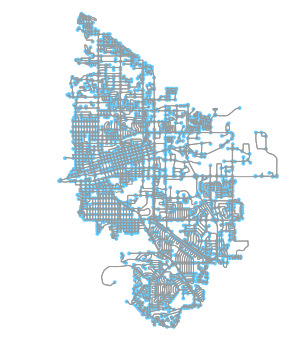

In [25]:
howlong('Boulder, Colorado, USA')

Shortest road: Baruch Place (13.80 meters)
Longest road: FDR Drive (31579.91 meters)


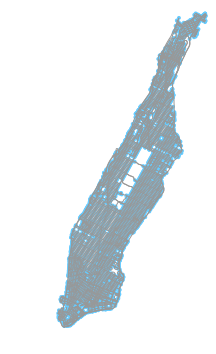

In [213]:
howlong('Manhattan, New York, USA')

Shortest road: Via Vespucci (10.43 meters)
Longest road: Belt Parkway (52746.25 meters)


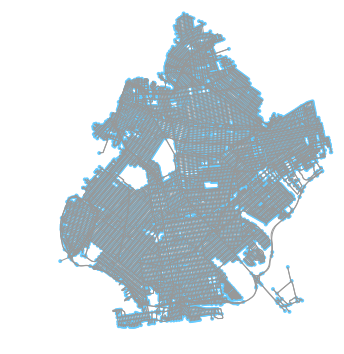

In [217]:
howlong('Brooklyn, NY')

Shortest road: Entrada Drive (16.69 meters)
Longest road: Ocean Park Boulevard (6950.16 meters)


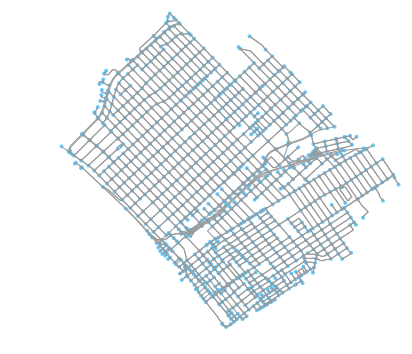

In [7]:
howlong('Santa Monica,LA')

In [15]:
def howcurve(place, ntype='drive'):
    """
    Find the straightest and curviest roads by name in a given geographical area in OSM.
    
    Args:
        1. place: a string of place name
        2. ntype: network type (not tested yet)
    Return:
        1. name and circuity info of the straightest road
        2. name and circuity info of the curviest road
        3. network graph plot of given place
    """
    
    # try different API query results
    try:
        G = ox.graph_from_place(place, network_type='drive', which_result=1)
    except:
        G = ox.graph_from_place(place, network_type='drive', which_result=2)
    
    # save and read as .shp file
    ox.save_graph_shapefile(G, filename='howcurve')
    G_edges = gpd.read_file('data/howcurve/edges/edges.shp')
    G_nodes = gpd.read_file('data/howcurve/nodes/nodes.shp')
    
    # extract road names
    roads = list(G_edges['name'].unique())
    #roads.remove('') ### remove messy segements without names ###
    rnames = []
    dist_v = []
    dist_r = []
    circuity = []
    
    # calculate circuity for each road
    for i,r in enumerate(roads):
        df_road = G_edges[G_edges['name'] == roads[i]]
        nor = list(df_road['from'].values) + list(df_road['to'].values)
        tdict = dict(Counter(nor))
        tdf = pd.DataFrame(list(tdict.items()), columns=['node', 'count'])
        tdf_sub = tdf[tdf['count']==1]

        if len(tdf_sub) != 2:
            
            continue ### skip roads with more than two terminal nodes for now ###

        else:
            
            G_nodes_term = G_nodes[list(map(lambda n: n in list(tdf_sub['node'].values), list(G_nodes['osmid'])))]
            coord1 = list(G_nodes_term.iloc[0,:]['geometry'].coords)[0]
            coord2 = list(G_nodes_term.iloc[1,:]['geometry'].coords)[0]
            p1 = coord1[1], coord1[0]
            p2 = coord2[1], coord2[0]

            d_v = vincenty(p1, p2).meters
            d_r = df_road['length'].astype('float', error='coerce').sum()
            circ = d_r / d_v

            rnames.append(r)
            dist_v.append(d_v)
            dist_r.append(d_r)
            circuity.append(circ)

    # create a dataframe with circuity data
    df_circ = pd.DataFrame({'name': rnames,
                            'dist_v': dist_v,
                            'dist_r': dist_r,
                            'circuity': circuity})

    # calculate straightest and curviest roads
    straight = df_circ.sort_values('circuity', ascending=True).head(1).iloc[0]
    curve = df_circ.sort_values('circuity', ascending=False).head(1).iloc[0]
    
    # output
    print('Straightest road: {:s}\nroad dist.: {:.2f}\nshortest dist.: {:.2f}\ncircuity: {:.5f}\n'.format(straight['name'], straight['dist_r'], straight['dist_v'], straight['circuity']))
    print('Curviest road: {:s}\nroad dist.: {:.2f}\nshortest dist.: {:.2f}\ncircuity: {:.5f}\n'.format(curve['name'], curve['dist_r'], curve['dist_v'], curve['circuity']))

    #ox.plot_graph(G);
    fig, ax = pl.subplots(figsize=(10,10))
    G_edges.plot(ax=ax)
    G_edges[G_edges['name'] == straight['name']].plot(color='red', ax=ax, label='straightest')
    G_edges[G_edges['name'] == curve['name']].plot(color='orange', ax=ax, label='curviest')
    pl.legend(fontsize='medium')
    pl.show()

Straightest road: Bixby Lane
road dist.: 6.50
shortest dist.: 6.52
circuity: 0.99745

Curviest road: South Broadway
road dist.: 5473.86
shortest dist.: 10.81
circuity: 506.32474



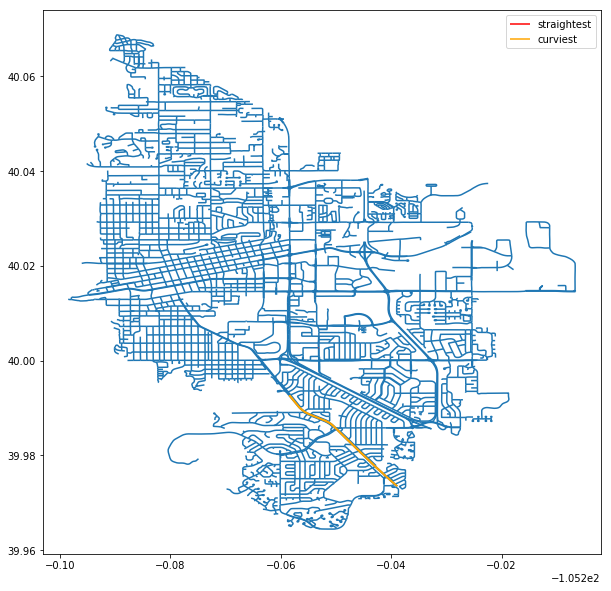

In [16]:
howcurve('Boulder, CO')

Straightest road: Bethune Street
road dist.: 281.07
shortest dist.: 281.79
circuity: 0.99746

Curviest road: Malcolm X Boulevard
road dist.: 5646.02
shortest dist.: 13.29
circuity: 424.79302



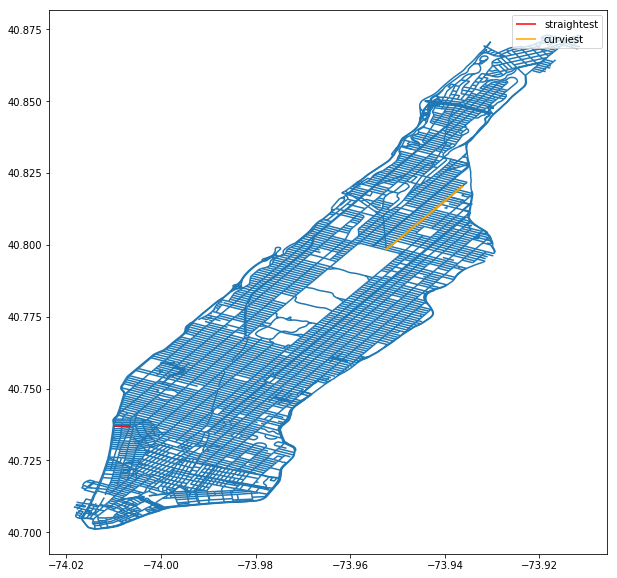

In [17]:
howcurve('Manhattan,NY')

Straightest road: Jodie Court
road dist.: 68.26
shortest dist.: 68.44
circuity: 0.99746

Curviest road: Surf Avenue
road dist.: 5857.77
shortest dist.: 11.59
circuity: 505.62797



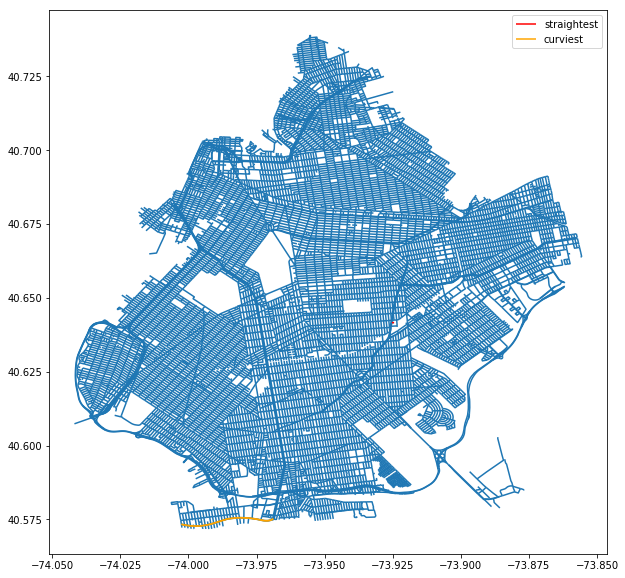

In [18]:
howcurve('Brooklyn,NY')

Straightest road: Exposition Boulevard
road dist.: 692.69
shortest dist.: 693.99
circuity: 0.99812

Curviest road: Palisades Beach Road
road dist.: 1226.83
shortest dist.: 77.76
circuity: 15.77671



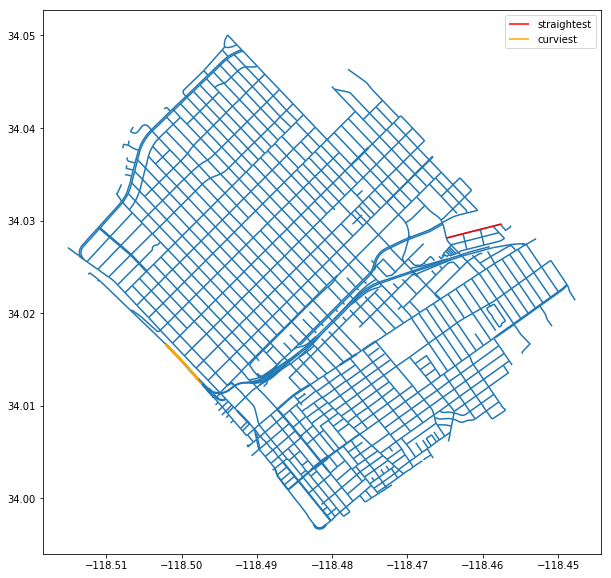

In [19]:
howcurve('Santa Monica,LA')

## Explore Nominatim forDetails

In [55]:
from geopy import Nominatim

In [56]:
geolocator = Nominatim()
location = geolocator.geocode("Broadway,Boulder,Colorado")
print(location.address)
print(location.raw)

Broadway, The Hill, Boulder, Boulder County, Colorado, 80309, United States of America
{'place_id': '163759479', 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://www.openstreetmap.org/copyright', 'osm_type': 'way', 'osm_id': '420432642', 'boundingbox': ['39.9966112', '39.9979125', '-105.2619956', '-105.2610971'], 'lat': '39.9967495', 'lon': '-105.2611941', 'display_name': 'Broadway, The Hill, Boulder, Boulder County, Colorado, 80309, United States of America', 'class': 'highway', 'type': 'primary', 'importance': 0.355}


In [75]:
location = geolocator.geocode("Bixby Lane,Boulder,Colorado")
print(location.address)
print(location.raw)

Bixby Lane, Boulder, Boulder County, Colorado, 80303, United States of America
{'place_id': '69503821', 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://www.openstreetmap.org/copyright', 'osm_type': 'way', 'osm_id': '17019546', 'boundingbox': ['40.002702', '40.002741', '-105.255933', '-105.2530868'], 'lat': '40.0027399', 'lon': '-105.2554139', 'display_name': 'Bixby Lane, Boulder, Boulder County, Colorado, 80303, United States of America', 'class': 'highway', 'type': 'residential', 'importance': 0.445}


## Limitations and Issues 

### Issue 1: Multiple road names  - Solutions: can just group by 'osmid' instead of group by names                                    
Name column appears to be in list form in saome ways and needs to be converted to string type again before it can be grouped by. The problem appears to be due to some road names being coded as lists containing 2 roads, e.g., ['Forrest Street', 'Garden Street'].

### Issue 2: Starting and ending nodes
Current method removes all node information, a later version should identify and update the nodes for a road after the segments are combined and keep them in the dataframe.

### Issue 3: Missing road name
This function soon ran into a problem: some edge does not have name and throws back a key error. This is handled by only extracting edges with a 'name' key in the attributes.